In [2]:
# Packages laden
import pandas as pd
import sklearn as skl
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import skew
%matplotlib inline
# erkärte Variable Verteilung prüfen
# Prüfen, welche Variablen falsch skaliert sind
# nA Values bearbeiten
# Ausreißer behandeln
# Kategoriale Variablen in faktoren unterteilen bzw. 
# Kategoriale Variablen one Hot coden


In [3]:
#Datei einlesen
#Datenstruktur und Variablen einsehen

house_data = pd.read_csv("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/housing_prices.csv", index_col = "Id")
house_data.head()
house_data.shape

skew(house_data["SalePrice"], axis=0) # Funktion zum identifizieren der Schiefe der Verteilung (aus dem scipy.stats package)
# house_data["SalePrice"].describe().to_excel("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/describe.xlsx") # hier wird die deskriptive statistik für SalePrice in meine lokale Excel-Datei exportiert



1.880940746034036

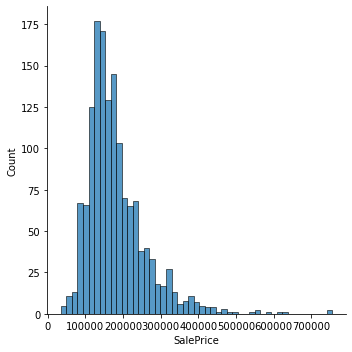

In [4]:
# deskriptive Statisitk der erklärten Variable

sns.displot(data=house_data["SalePrice"])
# house_data["SalePrice"].describe().to_excel("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/describe.xlsx") => wurde genutzt um die deskr. Statistik in ein lokales Excel Dokument zu exportieren


In [5]:
pd.options.display.max_columns = 81
df = pd.DataFrame(house_data)


# Position der erklärten Variable auf den Anfang des Datensatzes ändern (erste Spalte)
cols = list(df.columns)
cols = [cols[-1]] + cols[:-1]
df = df[cols]



In [6]:
df_regressors = df.loc[:, df.columns != "SalePrice"]

In [7]:
# Anzahl der Datentypen
df_regressors.dtypes.value_counts()

object     43
int64      33
float64     3
dtype: int64

In [9]:
# Missing Values Betrachtung (Credits: https://dzone.com/articles/pandas-dataframe-functionsplaying-with-multiple-da)
pd.options.display.max_rows = 81
missing_value_cnt = df.isnull().sum()

# Auflistung der Variablen mit fehlenden Werten
missing_columns = df.columns[df.isnull().any()].tolist()
missing_columns


['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [10]:
# Anzahl der fehlenden Werte in den Spalten
missing_value_cnt

SalePrice           0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

In [11]:
#numerische Variablen identifizieren und auf missing Values untersuchen

df_numerics = df.select_dtypes(include=np.number)
pd.set_option('display.max_columns', None)
#df_numerics.shape
#df_numerics
missing_columns_num = df_numerics.isnull().sum()
missing_columns_num



SalePrice          0
MSSubClass         0
LotFrontage      259
LotArea            0
OverallQual        0
OverallCond        0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
BsmtFullBath       0
BsmtHalfBath       0
FullBath           0
HalfBath           0
BedroomAbvGr       0
KitchenAbvGr       0
TotRmsAbvGrd       0
Fireplaces         0
GarageYrBlt       81
GarageCars         0
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
PoolArea           0
MiscVal            0
MoSold             0
YrSold             0
dtype: int64

In [12]:
# LotFrontage Missing Values untersuchen (Lotfrrontage is die Länge des Grundstücks, auf dem das Haus gebaut ist und das an der Straße grenzt)
df[df.LotFrontage.isna()].SalePrice.describe()
df[df.LotFrontage.isna()].SalePrice.describe().to_excel("C:/Users/Denis/OneDrive/Dokumente/Kurse/S8/angewandte Ökonometrie/describe_LotFrontage_Missing.xlsx")

In [13]:
# Erstmal kein Hinweis auf systematisches fehlen der Einträge (Mittelwert von SalesPrice bei den Beobachtungen mit fehlendem LotFrontage = Mittelwert insgesamt), daher Mittelwert-Imputation

mean_LotFrontage = df["LotFrontage"].mean()
df['LotFrontage'] = df['LotFrontage'].fillna(mean_LotFrontage)


df_numerics = df.select_dtypes(include=np.number)
missing_columns_num = df_numerics.isnull().sum()
missing_columns_num


SalePrice         0
MSSubClass        0
LotFrontage       0
LotArea           0
OverallQual       0
OverallCond       0
YearBuilt         0
YearRemodAdd      0
MasVnrArea        8
BsmtFinSF1        0
BsmtFinSF2        0
BsmtUnfSF         0
TotalBsmtSF       0
1stFlrSF          0
2ndFlrSF          0
LowQualFinSF      0
GrLivArea         0
BsmtFullBath      0
BsmtHalfBath      0
FullBath          0
HalfBath          0
BedroomAbvGr      0
KitchenAbvGr      0
TotRmsAbvGrd      0
Fireplaces        0
GarageYrBlt      81
GarageCars        0
GarageArea        0
WoodDeckSF        0
OpenPorchSF       0
EnclosedPorch     0
3SsnPorch         0
ScreenPorch       0
PoolArea          0
MiscVal           0
MoSold            0
YrSold            0
dtype: int64

In [14]:
# GarageYrBlt missing Values untersuchen: Falls in den 81 Zeilen jeweils alle "Garage" Variablen fehlen, gehe ich davon aus, dass keine Garage vorliegt. 

df_Garage = df.loc[:,['SalePrice','GarageYrBlt', 'GarageType','GarageFinish','GarageQual', 'GarageCond']]

df_GarageMissing = df_Garage
df_GarageMissing = df_GarageMissing[df_GarageMissing.isnull().any(axis=1)]
df_GarageMissing.shape
df_GarageMissing

# Tatsächlich fehlen in den beobachteten Fällen alle "Garage" Variablen gemeinsam, daher wahrscheinlich keine Garage vorhanden. 

,SalePrice,GarageYrBlt,GarageType,GarageFinish,GarageQual,GarageCond
Id,,,,,,
40,82000,NaN,NaN,NaN,NaN,NaN
49,113000,NaN,NaN,NaN,NaN,NaN
79,136500,NaN,NaN,NaN,NaN,NaN
89,85000,NaN,NaN,NaN,NaN,NaN
90,123600,NaN,NaN,NaN,NaN,NaN
100,128950,NaN,NaN,NaN,NaN,NaN
109,115000,NaN,NaN,NaN,NaN,NaN
126,84500,NaN,NaN,NaN,NaN,NaN
128,87000,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

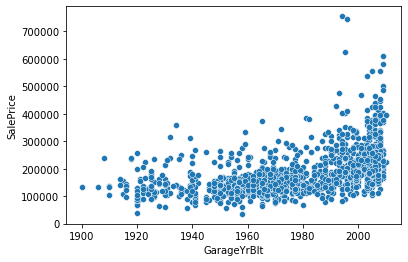

In [15]:
sns.scatterplot(data = df, x = 'GarageYrBlt', y = 'SalePrice') #ab ca. 1990 ist eine höhere positive Korrelation zwischen dem Baujahr und dem Preis zu sehen, daher werde ich 3 bins erstellen: keine Garage, vor 1990, nach 1990

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

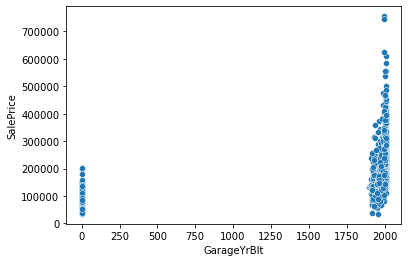

In [16]:
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(0)

sns.scatterplot(data = df, x = 'GarageYrBlt', y = 'SalePrice') #Gebäude, die einen Missing Value hatten bei Garagenvariablen, sind im Durchschnitt weniger wert. Ein Hinweis darauf, dass dort keine Garage verbaut ist

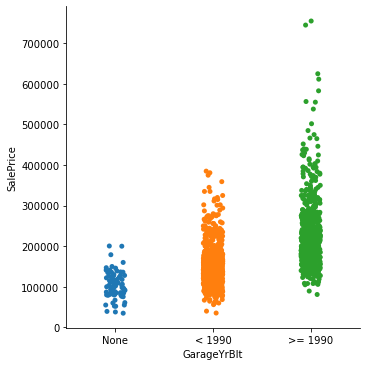

In [17]:
# bins erstellen für GarageYrBlt: keine Garage, Garage vor 1990 gebaur, Garage nach 1990 gebaut

bins = [-1, 1, 1990, 2300]
df_bins = pd.cut(df['GarageYrBlt'].to_list(), bins)
df_bins.categories = ['None', '< 1990', '>= 1990']
df['GarageYrBlt'] = df_bins
sns.catplot(x = 'GarageYrBlt', y = 'SalePrice', data = df) 

In [18]:
df

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,>= 1990,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,< 1990,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,>= 1990,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,>= 1990,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,>= 1990,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,175000,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,>= 1990,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,210000,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,< 1990,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,266500,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,< 1990,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


In [19]:
# als nächstes MasVnrArea Missing Values behandeln

df_numerics = df.select_dtypes(include=np.number)
missing_columns_num = df_numerics.isnull().sum()
missing_columns_num


SalePrice        0
MSSubClass       0
LotFrontage      0
LotArea          0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
MasVnrArea       8
BsmtFinSF1       0
BsmtFinSF2       0
BsmtUnfSF        0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
LowQualFinSF     0
GrLivArea        0
BsmtFullBath     0
BsmtHalfBath     0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageCars       0
GarageArea       0
WoodDeckSF       0
OpenPorchSF      0
EnclosedPorch    0
3SsnPorch        0
ScreenPorch      0
PoolArea         0
MiscVal          0
MoSold           0
YrSold           0
dtype: int64

In [20]:
# MasVnrArea Missing Values untersuchen

df['MasVnrType'].value_counts()
df_MasVnr = df[['SalePrice', 'MasVnrType', 'MasVnrArea']]
df_MasVnr


#Beobachtungen identifizieren, in denen MasVnrType Missing Values aufweist
null_data = df_MasVnr[df_MasVnr.isnull().any(axis=1)]
null_data




,SalePrice,MasVnrType,MasVnrArea
Id,,,
235,216500,NaN,NaN
530,200624,NaN,NaN
651,205950,NaN,NaN
937,184900,NaN,NaN
974,182000,NaN,NaN
978,199900,NaN,NaN
1244,465000,NaN,NaN
1279,237000,NaN,NaN


In [21]:
#Beobachtungen rausnehmen, bei denen MasVnrarea fehlt

df = df.drop(index = [235, 530, 651, 937, 974, 978, 1244, 1279])
df

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,>= 1990,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,< 1990,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,>= 1990,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,>= 1990,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,>= 1990,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,175000,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1999,2000,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,Unf,0,Unf,0,953,953,GasA,Ex,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,TA,7,Typ,1,TA,Attchd,>= 1990,RFn,2,460,TA,TA,Y,0,40,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal
1457,210000,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,1978,1988,Gable,CompShg,Plywood,Plywood,Stone,119.0,TA,TA,CBlock,Gd,TA,No,ALQ,790,Rec,163,589,1542,GasA,TA,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,TA,7,Min1,2,TA,Attchd,< 1990,Unf,2,500,TA,TA,Y,349,0,0,0,0,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal
1458,266500,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,1941,2006,Gable,CompShg,CemntBd,CmentBd,None,0.0,Ex,Gd,Stone,TA,Gd,No,GLQ,275,Unf,0,877,1152,GasA,Ex,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,Gd,9,Typ,2,Gd,Attchd,< 1990,RFn,1,252,TA,TA,Y,0,60,0,0,0,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal


In [22]:
# Nominal und Ordinal skalierte Variablen, die Nummern als Ausprägungen haben, aus der numerischen Tabelle nehmen.
df_numerics = df.select_dtypes(include=np.number)
df_numerics = df_numerics.drop(["MSSubClass", "OverallQual", "OverallCond", "MoSold", "YrSold", "YearBuilt", "YearRemodAdd"], axis = 1) #"GarageYrBlt"

In [23]:
df.loc[(df.YearBuilt < 1950) & (df.YearRemodAdd > 1960)]
df.loc[(df.YearBuilt == df.YearRemodAdd)]

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,60,RL,65.000000,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,>= 1990,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,181500,20,RL,80.000000,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,< 1990,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
5,250000,60,RL,84.000000,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,>= 1990,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
8,200000,60,RL,70.049958,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,< 1990,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal
11,129500,20,RL,70.000000,11200,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Sawyer,Norm,Norm,1Fam,1Story,5,5,1965,1965,Hip,CompShg,HdBoard,HdBoard,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,906,Unf,0,134,1040,GasA,Ex,Y,SBrkr,1040,0,0,1040,1,0,1,0,3,1,TA,5,Typ,0,NaN,Detchd,< 1990,Unf,1,384,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1450,92000,180,RM,21.000000,1533,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,SFoyer,5,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,Gd,TA,Av,GLQ,553,Unf,0,77,630,GasA,Ex,Y,SBrkr,630,0,0,630,1,0,1,0,1,1,Ex,3,Typ,0,NaN,NaN,None,NaN,0,0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,8,2006,WD,Abnorml
1451,136000,90,RL,60.000000,9000,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,NAmes,Norm,Norm,Duplex,2Story,5,5,1974,1974,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,Gd,TA,No,Unf,0,Unf,0,896,896,GasA,TA,Y,SBrkr,896,896,0,1792,0,0,2,2,4,2,TA,8,Typ,0,NaN,NaN,None,NaN,0,0,NaN,NaN,Y,32,45,0,0,0,0,NaN,NaN,NaN,0,9,2009,WD,Normal
1453,145000,180,RM,35.000000,3675,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Edwards,Norm,Norm,TwnhsE,SLvl,5,5,2005,2005,Gable,CompShg,VinylSd,VinylSd,BrkFace,80.0,TA,TA,PConc,Gd,TA,Gd,GLQ,547,Unf,0,0,547,GasA,Gd,Y,SBrkr,1072,0,0,1072,1,0,1,0,2,1,TA,5,Typ,0,NaN,Basment,>= 1990,Fin,2,525,TA,TA,Y,0,28,0,0,0,0,NaN,NaN,NaN,0,5,2006,WD,Normal


In [24]:
# Aus Yearsold unf YearRemodAdd eine neue Variable machen: Alter des Hauses

df.YrSold.max() # 2010 wurde das letzte Haus verkauft in diesem Datensatz, daher nehme ich 2010 als aktuelles Jahr an 
#sns.scatterplot(x = 'YearRemodAdd', y = 'SalePrice', data = df)

2010

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

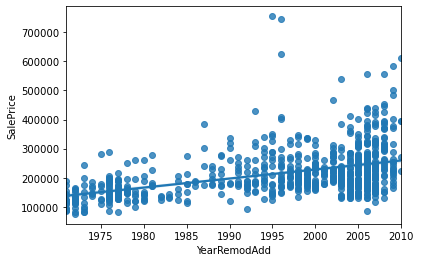

In [25]:
sns.regplot(x = 'YearRemodAdd', y = 'SalePrice', data = df.loc[df.YearBuilt >1970])

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

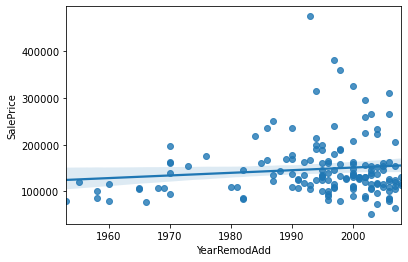

In [26]:
# tendenziell scheinen ältere Häuser auch nach einer Sarnierung wenig an Wert zu haben, verglichen mit neuen Gebäuden. Für das Alter werde ich nur das Baujahr berücksichtigen.

sns.regplot(x = 'YearRemodAdd', y = 'SalePrice', data = df.loc[(df.YearRemodAdd >1950) & (df.YearBuilt < 1950)]) 

In [27]:
df["CurrentYear"] = 2010
df["Age"] = df["CurrentYear"] - df["YearBuilt"]
df = df.drop(["CurrentYear"], axis = 1)
df_numerics["Age"] = df["Age"]
df = df.drop(['YearBuilt','YearRemodAdd'], axis = 1)

In [28]:
df_numerics.Age

Id
1        7
2       34
3        9
4       95
5       10
        ..
1456    11
1457    32
1458    69
1459    60
1460    45
Name: Age, Length: 1452, dtype: int64

In [29]:
# Numersiche Variablen auf Korrelationen prüfen
corr_numerics = df_numerics.corr()
corr_numerics.head()
#corr_numerics.shape

#Spalten aus der Korrelationsmatrix rausnehmen, die eine kleine Korrelation von unter 0,4 aufweisen
drop_columns = []
for i in range(0,len(df_numerics.columns)):
    if abs(corr_numerics.iloc[0][i]) < 0.4:
        drop_columns.append(i)

corr_numerics = corr_numerics.drop(corr_numerics.columns[drop_columns],axis=1)

#Zeilen aus der Korrelationsmatrix nehmen, die eine kleine Korrelation von unter 0,5 aufweisen. Jetzt wird die Korrelationsmatrix wieder quadratisch
drop_rowlabels = []
for i in drop_columns:
    drop_rowlabels.append(corr_numerics.index[i])
corr_numerics = corr_numerics.drop(drop_rowlabels)

# SalesPrice war zweimal in der korrelationsmatrix, deshalb eine SalesPrice Zeile und Spalte aus der Matrix nehmen
#corr_numerics = corr_numerics.iloc[:-1,:-1]

In [30]:
corr_numerics.tail()
corr_numerics.shape

(11, 11)

<AxesSubplot:>

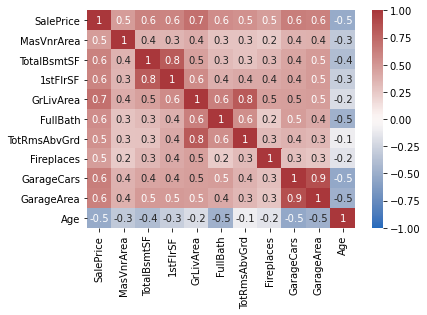

In [31]:
sns.heatmap(corr_numerics, vmin = -1 , vmax = 1, annot = True, cmap = "vlag", fmt = '.1g')

In [32]:
# da Garagecars und GarageArea beide den gleichen Effekt darstellen (Größe der garage), eliminiere ich eine der beiden (hohe Korrelation untereinander)
df = df.drop("GarageCars", axis = 1)

Die höchsten Korrelationen zur Erklärten Variable weisen OverallQual, GrLivArea und GarageCars auf. Außerdem bestehen zwischen einigen erklärenden Variablen eine hohe Korrelation. 

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

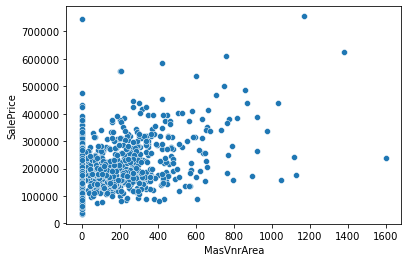

In [33]:
# Ausreißer identifizieren

#sns.scatterplot(data = df, x = 'MasVnrArea', y = 'SalePrice')
#df= df[df['MasVnrArea'] < 500]
sns.scatterplot(data = df, x = 'MasVnrArea', y = 'SalePrice')

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

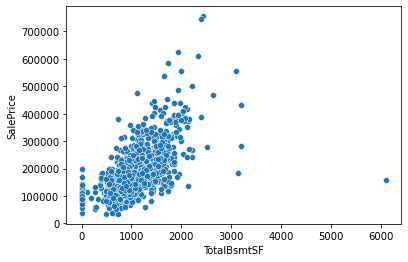

In [34]:
#df= df[df['TotalBsmtSF'] < 5000]
sns.scatterplot(data = df, x = 'TotalBsmtSF', y = 'SalePrice')  # Ausreißer bei über 6000 qm Kellerfläche, im nächsten Schritt eliminieren


<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

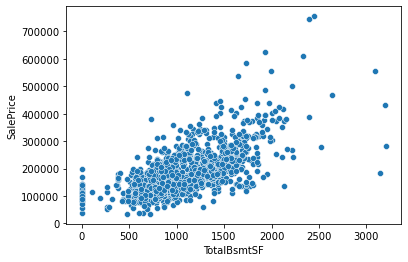

In [35]:
#credits https://stackoverflow.com/questions/23199796/detect-and-exclude-outliers-in-pandas-data-frame

df = df[df['TotalBsmtSF'] < 5000] # Ausreißer mit über 6000 Quadratmeter Kellerfläche eliminieren
sns.scatterplot(data = df, x = 'TotalBsmtSF', y = 'SalePrice') 

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

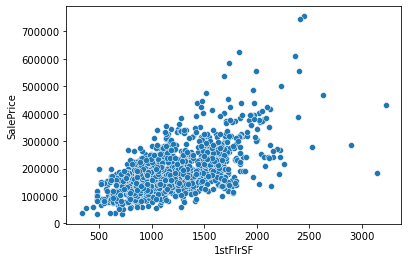

In [36]:
sns.scatterplot(data = df, x = '1stFlrSF', y = 'SalePrice')

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

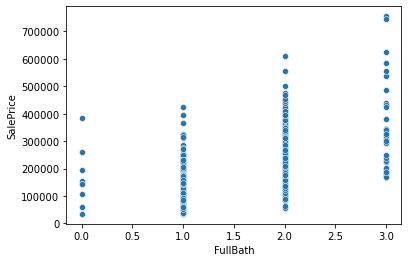

In [37]:
sns.scatterplot(data = df, x = 'FullBath', y = 'SalePrice')

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

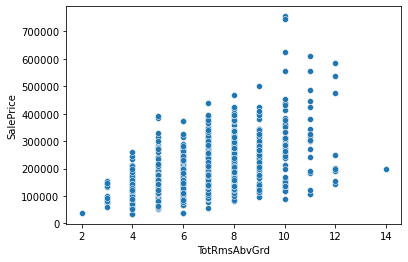

In [38]:
sns.scatterplot(data = df, x = 'TotRmsAbvGrd', y = 'SalePrice')

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

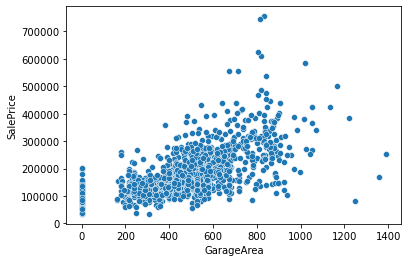

In [39]:
sns.scatterplot(data = df, x = 'GarageArea', y = 'SalePrice')

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

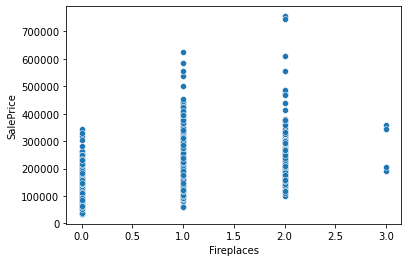

In [40]:
sns.scatterplot(data = df, x = 'Fireplaces', y = 'SalePrice')

In [41]:
# Auflistung nominal und ordinal skalierter Variablen (credits: https://stackoverflow.com/questions/29803093/check-which-columns-in-dataframe-are-categorical)
columns_dont_want = []
for i in df_numerics:
    columns_dont_want.append(i)
select = [x for x in df.columns if x not in columns_dont_want]
#df_chars = pd.DataFrame(house_data[select])
df_chars = pd.DataFrame(df[select])
df_chars.shape



(1451, 49)

In [42]:
df_chars.shape


(1451, 49)

In [43]:
len(df_chars.columns)

49

In [44]:
# Ordinale Variablen in einen DataFrame ziehen und kodieren für Kendalls Korrelation mit HousePrice (Credits:https://journals.sagepub.com/doi/pdf/10.1177/8756479308317006)

df_ordinals = pd.DataFrame(data = df_chars, columns = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence'])
df_ordinals.dtypes
df_ordinals

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
Id,,,,,,,,,,,,,,,
1,Gd,TA,Gd,TA,No,GLQ,Unf,Ex,Gd,NaN,RFn,TA,TA,NaN,NaN
2,TA,TA,Gd,TA,Gd,ALQ,Unf,Ex,TA,TA,RFn,TA,TA,NaN,NaN
3,Gd,TA,Gd,TA,Mn,GLQ,Unf,Ex,Gd,TA,RFn,TA,TA,NaN,NaN
4,TA,TA,TA,Gd,No,ALQ,Unf,Gd,Gd,Gd,Unf,TA,TA,NaN,NaN
5,Gd,TA,Gd,TA,Av,GLQ,Unf,Ex,Gd,TA,RFn,TA,TA,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,TA,TA,Gd,TA,No,Unf,Unf,Ex,TA,TA,RFn,TA,TA,NaN,NaN
1457,TA,TA,Gd,TA,No,ALQ,Rec,TA,TA,TA,Unf,TA,TA,NaN,MnPrv
1458,Ex,Gd,TA,Gd,No,GLQ,Unf,Ex,Gd,Gd,RFn,TA,TA,NaN,GdPrv


"ExterQual", "ExterCond", "HeatingQC", "KitchenQual" benutzen die selben ordinalen Kategorien. 
Darüber hinaus benutzen "BsmtQual", "BsmtCond","FireplaceQu", "GarageQual", "GarageCond" ebenfalls die gleichen Levels, zusätzlich mit einem Level "NA".
"PoolQC", "BsmtFinType2", "Fence" nutzen andere Levels 

In [45]:


cat1_Vars = ["ExterQual", "ExterCond", "HeatingQC", "KitchenQual"]
cat1 = pd.CategoricalDtype(categories=['Po','Fa','TA','Gd','Ex'], ordered = True)

for col in cat1_Vars:
    df_ordinals[col] = df_ordinals[col].astype(dtype = cat1).cat.codes

# bei den folgenden Variablen bedeutet ein fehlender Eintrag, dass zum Beispiel kein Keller oder keine Garage vorhaden ist. Deshalb NaN ersetzen mit None.

cat2_Vars = ["BsmtQual", "BsmtCond","FireplaceQu", "GarageQual", "GarageCond"]
cat2 = pd.CategoricalDtype(categories=['None','Po','Fa','TA','Gd','Ex'], ordered = True)

for col in cat2_Vars:
    df_ordinals[col] = df_ordinals[col].fillna("None")

    
for col in cat2_Vars:
    df_ordinals[col] = df_ordinals[col].astype(dtype = cat2).cat.codes

    


In [46]:
# "BsmtExporsure", "BsmtFinType1", "GarageFinish", "PoolQC" und "Fence" manuell umcodieren.

df_ordinals["BsmtExposure"] = df_ordinals["BsmtExposure"].fillna("None")
df_ordinals.head(50)

cat3 = pd.CategoricalDtype(categories = ['None','No', 'Mn', 'Av', 'Gd'], ordered = True)
df_ordinals["BsmtExposure"] = df_ordinals["BsmtExposure"].astype(dtype = cat3).cat.codes



In [47]:
df_ordinals["BsmtFinType1"] = df_ordinals["BsmtFinType1"].fillna("None")

cat4 = pd.CategoricalDtype(categories = ['None','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered = True)
df_ordinals["BsmtFinType1"] = df_ordinals["BsmtFinType1"].astype(dtype = cat4).cat.codes

In [48]:
df_ordinals["BsmtFinType2"] = df_ordinals["BsmtFinType2"].fillna("None")

cat5 = pd.CategoricalDtype(categories = ['None','Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'], ordered = True)
df_ordinals["BsmtFinType2"] = df_ordinals["BsmtFinType2"].astype(dtype = cat5).cat.codes

In [49]:
df_ordinals["GarageFinish"] = df_ordinals["GarageFinish"].fillna("None")

cat6 = pd.CategoricalDtype(categories = ['None','Unf', 'RFn', 'Fin'], ordered = True)
df_ordinals["GarageFinish"] = df_ordinals["GarageFinish"].astype(dtype = cat6).cat.codes

In [50]:
df_ordinals["PoolQC"] = df_ordinals["PoolQC"].fillna("None")

cat7 = pd.CategoricalDtype(categories = ['None','Fa', 'TA', 'Gd', 'Ex'], ordered = True)
df_ordinals["PoolQC"] = df_ordinals["PoolQC"].astype(dtype = cat7).cat.codes

In [51]:
df_ordinals["Fence"] = df_ordinals["Fence"].fillna("None")

cat8= pd.CategoricalDtype(categories = ['None','MnWw', 'GdWo', 'MnPrv', 'GdPrv'], ordered = True) #Fraglich, wie die Reihenfolge ist
df_ordinals["Fence"] = df_ordinals["Fence"].astype(dtype = cat8).cat.codes

In [52]:
df_ordinals

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence
Id,,,,,,,,,,,,,,,
1,3,2,4,3,1,6,1,4,3,0,2,3,3,0,0
2,2,2,4,3,4,5,1,4,2,3,2,3,3,0,0
3,3,2,4,3,2,6,1,4,3,3,2,3,3,0,0
4,2,2,3,4,1,5,1,3,3,4,1,3,3,0,0
5,3,2,4,3,3,6,1,4,3,3,2,3,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2,2,4,3,1,1,1,4,2,3,2,3,3,0,0
1457,2,2,4,3,1,5,3,2,2,3,1,3,3,0,3
1458,4,3,3,4,1,6,1,4,3,4,2,3,3,0,4


In [53]:
#numerische Variablen mit ordinaler skalierung in df_ordinals aufnehmen

df_ordinals["OverallQual"] = df["OverallQual"].values
df_ordinals["OverallCond"] = df["OverallCond"].values
#df_ordinals["SalePrice"] = df["SalePrice"].values


In [54]:
df_ordinals

,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,HeatingQC,KitchenQual,FireplaceQu,GarageFinish,GarageQual,GarageCond,PoolQC,Fence,OverallQual,OverallCond
Id,,,,,,,,,,,,,,,,,
1,3,2,4,3,1,6,1,4,3,0,2,3,3,0,0,7,5
2,2,2,4,3,4,5,1,4,2,3,2,3,3,0,0,6,8
3,3,2,4,3,2,6,1,4,3,3,2,3,3,0,0,7,5
4,2,2,3,4,1,5,1,3,3,4,1,3,3,0,0,7,5
5,3,2,4,3,3,6,1,4,3,3,2,3,3,0,0,8,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,2,2,4,3,1,1,1,4,2,3,2,3,3,0,0,6,5
1457,2,2,4,3,1,5,3,2,2,3,1,3,3,0,3,6,6
1458,4,3,3,4,1,6,1,4,3,4,2,3,3,0,4,7,9


In [55]:
# Ordinal skalierte Variablen mit numerischen Werden wieder in das Hauptdataframe df aufnehmnen

for i in df_ordinals.columns:
    df[i] = df_ordinals[i]

df


,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,6,706,1,0,150,856,GasA,4,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,3,8,Typ,0,0,Attchd,>= 1990,2,548,3,3,Y,0,61,0,0,0,0,0,0,NaN,0,2,2008,WD,Normal,7
2,181500,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,4,3,4,5,978,1,0,284,1262,GasA,4,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,2,6,Typ,1,3,Attchd,< 1990,2,460,3,3,Y,298,0,0,0,0,0,0,0,NaN,0,5,2007,WD,Normal,34
3,223500,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,6,486,1,0,434,920,GasA,4,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,3,6,Typ,1,3,Attchd,>= 1990,2,608,3,3,Y,0,42,0,0,0,0,0,0,NaN,0,9,2008,WD,Normal,9
4,140000,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,4,1,5,216,1,0,540,756,GasA,3,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,3,7,Typ,1,4,Detchd,>= 1990,1,642,3,3,Y,0,35,272,0,0,0,0,0,NaN,0,2,2006,WD,Abnorml,95
5,250000,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,6,655,1,0,490,1145,GasA,4,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,3,9,Typ,1,3,Attchd,>= 1990,2,836,3,3,Y,192,84,0,0,0,0,0,0,NaN,0,12,2008,WD,Normal,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,175000,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,PConc,4,3,1,1,0,1,0,953,953,GasA,4,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,2,7,Typ,1,3,Attchd,>= 1990,2,460,3,3,Y,0,40,0,0,0,0,0,0,NaN,0,8,2007,WD,Normal,11
1457,210000,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,2,2,CBlock,4,3,1,5,790,3,163,589,1542,GasA,2,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,2,7,Min1,2,3,Attchd,< 1990,1,500,3,3,Y,349,0,0,0,0,0,0,3,NaN,0,2,2010,WD,Normal,32
1458,266500,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,None,0.0,4,3,Stone,3,4,1,6,275,1,0,877,1152,GasA,4,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,3,9,Typ,2,4,Attchd,< 1990,2,252,3,3,Y,0,60,0,0,0,0,0,4,Shed,2500,5,2010,WD,Normal,69


In [56]:
# Kategoriale Variablen auf Missing Values überprüfen

columns_dont_want2 = []
for i in df_ordinals:
    columns_dont_want2.append(i)
select2 = [x for x in df_chars.columns if x not in columns_dont_want2]

df_categoricals = pd.DataFrame(df[select2])
#df_categoricals = df_categoricals.drop(["YearBuilt"], axis=1)
#df_categoricals = df_categoricals.drop(["YearRemodAdd"], axis=1)
df_categoricals["SalePrice"] = df["SalePrice"]

In [57]:
# Kategoriialvariablen, die als Integer hinterlegt sind, prüfen und gegebenenfalls transformieren

df_categoricals.dtypes

df["MSSubClass"] = df["MSSubClass"].astype("object") 

<AxesSubplot:xlabel='YrSold', ylabel='SalePrice'>

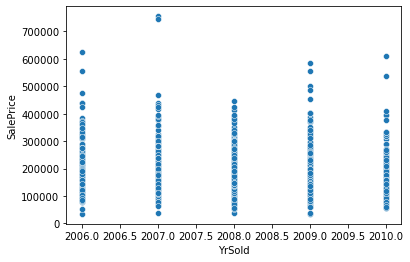

In [58]:
sns.scatterplot(data = df_categoricals, x = "YrSold", y = "SalePrice")


<AxesSubplot:xlabel='MoSold', ylabel='SalePrice'>

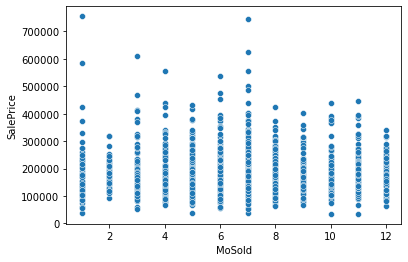

In [59]:
sns.scatterplot(data = df_categoricals, x = "MoSold", y = "SalePrice") 

In [60]:
df_categoricals["YrSold"].unique() # YrSold hat nur 5 Kategorien, daher keine umcodierung, YrSold und MoSold zu Kategorien umtransformieren
df[["YrSold", "MoSold"]] = df[["YrSold", "MoSold"]].astype("object")

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

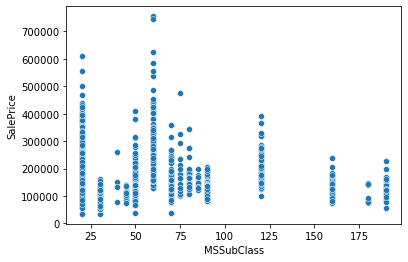

In [61]:
sns.scatterplot(data = df_categoricals, x = "MSSubClass", y = "SalePrice") # starke henterogenität zwischen den Kategorien, aber teils nur wenige Beobachtungen innerhalb der Kategorie

In [62]:
df["MSSubClass"] = df["MSSubClass"].astype("object")
df.dtypes

SalePrice           int64
MSSubClass         object
MSZoning           object
LotFrontage       float64
LotArea             int64
Street             object
Alley              object
LotShape           object
LandContour        object
Utilities          object
LotConfig          object
LandSlope          object
Neighborhood       object
Condition1         object
Condition2         object
BldgType           object
HouseStyle         object
OverallQual         int64
OverallCond         int64
RoofStyle          object
RoofMatl           object
Exterior1st        object
Exterior2nd        object
MasVnrType         object
MasVnrArea        float64
ExterQual            int8
ExterCond            int8
Foundation         object
BsmtQual             int8
BsmtCond             int8
BsmtExposure         int8
BsmtFinType1         int8
BsmtFinSF1          int64
BsmtFinType2         int8
BsmtFinSF2          int64
BsmtUnfSF           int64
TotalBsmtSF         int64
Heating            object
HeatingQC   

In [63]:
# Missing Values der Kategorialvariablen prüfen
df_categoricals.isnull().sum()

MSSubClass          0
MSZoning            0
Street              0
Alley            1361
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          0
Foundation          0
Heating             0
CentralAir          0
Electrical          1
Functional          0
GarageType         81
GarageYrBlt         0
PavedDrive          0
MiscFeature      1397
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
SalePrice           0
dtype: int64

In [64]:
# "Alley" und "Misc" Variablen rausnehmen, da der Großteil der Beobachtungen NaN ist 
#sns.scatterplot(data = df_categoricals, x = "MiscFeature", y = "SalePrice")
df_categoricals = df_categoricals.drop("MiscFeature", axis = 1)
df = df.drop("MiscFeature", axis = 1)
df_categoricals = df_categoricals.drop("Alley", axis = 1)
df = df.drop("Alley", axis = 1)
#df_categoricals

In [65]:
# Garagetype Missing Values resultieren, wie weiter oben erläutert, wahrscheinlich aus dem Nichtvorhandensein einer Garage. NaN werden mit "None" ersetzt

df["GarageType"] = df["GarageType"].fillna("None") 

In [66]:
# Beobachtung rausnehmen, bei der "Electrical" einen Missing Value aufweist

df.Electrical[df["Electrical"].isna()]
df_categoricals = df_categoricals.drop(index = 1380)
df = df.drop(index = 1380) # vielleicht lieber imputation des modus
df_categoricals.isnull().sum()

MSSubClass        0
MSZoning          0
Street            0
LotShape          0
LandContour       0
Utilities         0
LotConfig         0
LandSlope         0
Neighborhood      0
Condition1        0
Condition2        0
BldgType          0
HouseStyle        0
RoofStyle         0
RoofMatl          0
Exterior1st       0
Exterior2nd       0
MasVnrType        0
Foundation        0
Heating           0
CentralAir        0
Electrical        0
Functional        0
GarageType       81
GarageYrBlt       0
PavedDrive        0
MoSold            0
YrSold            0
SaleType          0
SaleCondition     0
SalePrice         0
dtype: int64

In [67]:
df

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,6,706,1,0,150,856,GasA,4,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,3,8,Typ,0,0,Attchd,>= 1990,2,548,3,3,Y,0,61,0,0,0,0,0,0,0,2,2008,WD,Normal,7
2,181500,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,4,3,4,5,978,1,0,284,1262,GasA,4,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,2,6,Typ,1,3,Attchd,< 1990,2,460,3,3,Y,298,0,0,0,0,0,0,0,0,5,2007,WD,Normal,34
3,223500,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,6,486,1,0,434,920,GasA,4,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,3,6,Typ,1,3,Attchd,>= 1990,2,608,3,3,Y,0,42,0,0,0,0,0,0,0,9,2008,WD,Normal,9
4,140000,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,4,1,5,216,1,0,540,756,GasA,3,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,3,7,Typ,1,4,Detchd,>= 1990,1,642,3,3,Y,0,35,272,0,0,0,0,0,0,2,2006,WD,Abnorml,95
5,250000,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,6,655,1,0,490,1145,GasA,4,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,3,9,Typ,1,3,Attchd,>= 1990,2,836,3,3,Y,192,84,0,0,0,0,0,0,0,12,2008,WD,Normal,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,175000,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,PConc,4,3,1,1,0,1,0,953,953,GasA,4,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,2,7,Typ,1,3,Attchd,>= 1990,2,460,3,3,Y,0,40,0,0,0,0,0,0,0,8,2007,WD,Normal,11
1457,210000,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,2,2,CBlock,4,3,1,5,790,3,163,589,1542,GasA,2,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,2,7,Min1,2,3,Attchd,< 1990,1,500,3,3,Y,349,0,0,0,0,0,0,3,0,2,2010,WD,Normal,32
1458,266500,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,None,0.0,4,3,Stone,3,4,1,6,275,1,0,877,1152,GasA,4,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,3,9,Typ,2,4,Attchd,< 1990,2,252,3,3,Y,0,60,0,0,0,0,0,4,2500,5,2010,WD,Normal,69


In [68]:
# auf starke Korrelationen zwischen den erklärenden numerischen Variablen schauen (Credits: https://www.dezyre.com/recipes/drop-out-highly-correlated-features-in-python)

df_numerics = df.select_dtypes(include=np.number)
df_numerics_corr = df_numerics.corr().abs()
df_numerics_corr = df_numerics_corr.drop('SalePrice')
df_numerics_corr = df_numerics_corr.drop('SalePrice', axis = 1)


In [69]:
upper_tri = df_numerics_corr.where(np.triu(np.ones(df_numerics_corr.shape),k=1).astype(np.bool))
upper_tri

,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageArea,GarageQual,GarageCond,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,Age
LotFrontage,NaN,0.280981,0.221247,0.050719,0.158242,0.149037,0.014194,0.133315,0.046299,0.150126,0.069487,0.142712,0.022035,0.047952,0.127167,0.301895,0.085622,0.371804,0.065744,0.039653,0.329525,0.072667,0.004591,0.180681,0.041310,0.246303,0.004264,0.157909,0.308478,0.218369,0.225663,0.216114,0.304796,0.111394,0.106394,0.071876,0.112306,0.013455,0.066310,0.041863,0.100327,0.140812,0.036449,0.001999,0.112906
LotArea,NaN,NaN,0.097107,0.000382,0.091413,0.044744,0.016018,0.067944,0.030786,0.224180,0.056409,0.181022,0.088975,0.113871,0.003440,0.228927,0.002650,0.272827,0.048394,0.005395,0.239685,0.148433,0.049749,0.120816,0.011949,0.118359,0.024173,0.061934,0.178040,0.259795,0.182047,0.121532,0.167266,0.079058,0.075789,0.171405,0.073651,0.022009,0.021208,0.044943,0.036379,0.041359,0.039763,0.038931,0.011319
OverallQual,NaN,NaN,NaN,0.090182,0.407419,0.723223,0.015490,0.627626,0.266746,0.292456,0.228889,0.225098,0.042999,0.057808,0.310772,0.541212,0.455463,0.473980,0.297340,0.029918,0.593474,0.102791,0.038985,0.553036,0.270824,0.105988,0.184903,0.670994,0.427092,0.395823,0.491458,0.556574,0.557175,0.292930,0.287429,0.239605,0.298206,0.112791,0.031286,0.066987,0.044961,0.062342,0.150598,0.031098,0.571616
OverallCond,NaN,NaN,NaN,NaN,0.127617,0.135382,0.389266,0.164473,0.134030,0.057597,0.013036,0.040038,0.100805,0.039135,0.137201,0.171891,0.014133,0.140105,0.028238,0.025058,0.075440,0.050953,0.117143,0.189944,0.060625,0.014394,0.081422,0.025134,0.054874,0.019231,0.055872,0.168699,0.150648,0.020217,0.017870,0.004173,0.030244,0.074494,0.025084,0.053834,0.002105,0.010748,0.168256,0.068592,0.376347
MasVnrArea,NaN,NaN,NaN,NaN,NaN,0.346637,0.018394,0.277518,0.074575,0.170063,0.184338,0.246906,0.045519,0.072046,0.115488,0.351458,0.158085,0.331453,0.172211,0.069158,0.380162,0.077642,0.027357,0.276599,0.199924,0.102989,0.037333,0.282432,0.274407,0.241376,0.273887,0.278370,0.365647,0.136039,0.134837,0.158087,0.116801,0.109976,0.019156,0.062399,0.020663,0.027725,0.097875,0.029772,0.314873
ExterQual,NaN,NaN,NaN,NaN,NaN,NaN,0.011293,0.563374,0.182311,0.246392,0.222506,0.185955,0.060924,0.074429,0.287245,0.469094,0.519174,0.390613,0.180207,0.062563,0.430532,0.115058,0.054683,0.483368,0.190207,0.017076,0.155034,0.714619,0.295096,0.244193,0.362075,0.516662,0.490522,0.218654,0.214249,0.208670,0.281869,0.150663,0.038235,0.015102,0.013162,0.030288,0.231963,0.038889,0.596995
ExterCond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.018210,0.145468,0.005692,0.061368,0.045830,0.069230,0.059984,0.070320,0.003556,0.056633,0.000801,0.025250,0.032531,0.018903,0.039479,0.097616,0.002038,0.032929,0.014993,0.050292,0.059355,0.001694,0.028918,0.005721,0.014451,0.021754,0.095397,0.104422,0.046843,0.065463,0.035165,0.005007,0.028162,0.048661,0.058581,0.068960,0.051516,0.102774
BsmtQual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.633720,0.398429,0.376870,0.305362,0.087020,0.029700,0.258968,0.580763,0.394743,0.293575,0.139978,0.055364,0.326634,0.220275,0.012241,0.371607,0.226131,0.038058,0.277640,0.507285,0.184181,0.229060,0.308019,0.482760,0.402747,0.181557,0.192146,0.252419,0.248219,0.179692,0.008683,0.035811,0.013287,0.017657,0.146930,0.044114,0.600888
BsmtCond,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.254394,0.299074,0.170791,0.243688,0.082633,0.169101,0.389003,0.170900,0.051129,0.058287,0.033440,0.083377,0.155698,0.065408,0.040697,0.132909,0.003399,0.270091,0.180157,0.024054,0.102527,0.114514,0.181961,0.139844,0.128402,0.144295,0.123537,0.093690,0.040913,0.008922,0.039931,0.007647,0.006986,0.018266,0.023090,0.181865
Bs

In [70]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.95)]
print(to_drop)

# GarageCond und GarageQuality korrelieren stark, daher eine der Variablen eliminieren
df = df.drop('GarageCond', axis = 1)

['GarageCond']


In [71]:
df

,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageArea,GarageQual,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,MoSold,YrSold,SaleType,SaleCondition,Age
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,3,2,PConc,4,3,1,6,706,1,0,150,856,GasA,4,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,3,8,Typ,0,0,Attchd,>= 1990,2,548,3,Y,0,61,0,0,0,0,0,0,0,2,2008,WD,Normal,7
2,181500,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,0.0,2,2,CBlock,4,3,4,5,978,1,0,284,1262,GasA,4,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,2,6,Typ,1,3,Attchd,< 1990,2,460,3,Y,298,0,0,0,0,0,0,0,0,5,2007,WD,Normal,34
3,223500,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,3,2,PConc,4,3,2,6,486,1,0,434,920,GasA,4,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,3,6,Typ,1,3,Attchd,>= 1990,2,608,3,Y,0,42,0,0,0,0,0,0,0,9,2008,WD,Normal,9
4,140000,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,2,2,BrkTil,3,4,1,5,216,1,0,540,756,GasA,3,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,3,7,Typ,1,4,Detchd,>= 1990,1,642,3,Y,0,35,272,0,0,0,0,0,0,2,2006,WD,Abnorml,95
5,250000,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,3,2,PConc,4,3,3,6,655,1,0,490,1145,GasA,4,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,3,9,Typ,1,3,Attchd,>= 1990,2,836,3,Y,192,84,0,0,0,0,0,0,0,12,2008,WD,Normal,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,175000,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,0.0,2,2,PConc,4,3,1,1,0,1,0,953,953,GasA,4,Y,SBrkr,953,694,0,1647,0,0,2,1,3,1,2,7,Typ,1,3,Attchd,>= 1990,2,460,3,Y,0,40,0,0,0,0,0,0,0,8,2007,WD,Normal,11
1457,210000,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,119.0,2,2,CBlock,4,3,1,5,790,3,163,589,1542,GasA,2,Y,SBrkr,2073,0,0,2073,1,0,2,0,3,1,2,7,Min1,2,3,Attchd,< 1990,1,500,3,Y,349,0,0,0,0,0,0,3,0,2,2010,WD,Normal,32
1458,266500,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,None,0.0,4,3,Stone,3,4,1,6,275,1,0,877,1152,GasA,4,Y,SBrkr,1188,1152,0,2340,0,0,2,0,4,1,3,9,Typ,2,4,Attchd,< 1990,2,252,3,Y,0,60,0,0,0,0,0,4,2500,5,2010,WD,Normal,69


In [72]:
#df_chars = df.select_dtypes('object')
#df_chars['GarageYrBlt']=df['GarageYrBlt'] 

In [73]:
df_chars

,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,NaN,Attchd,>= 1990,RFn,TA,TA,Y,NaN,NaN,NaN,2,2008,WD,Normal
2,20,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,Gable,CompShg,MetalSd,MetalSd,None,TA,TA,CBlock,Gd,TA,Gd,ALQ,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,< 1990,RFn,TA,TA,Y,NaN,NaN,NaN,5,2007,WD,Normal
3,60,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Mn,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,>= 1990,RFn,TA,TA,Y,NaN,NaN,NaN,9,2008,WD,Normal
4,70,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,Gable,CompShg,Wd Sdng,Wd Shng,None,TA,TA,BrkTil,TA,Gd,No,ALQ,Unf,GasA,Gd,Y,SBrkr,Gd,Typ,Gd,Detchd,>= 1990,Unf,TA,TA,Y,NaN,NaN,NaN,2,2006,WD,Abnorml
5,60,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,Gable,CompShg,VinylSd,VinylSd,BrkFace,Gd,TA,PConc,Gd,TA,Av,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,TA,Attchd,>= 1990,RFn,TA,TA,Y,NaN,NaN,NaN,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,Gable,CompShg,VinylSd,VinylSd,None,TA,TA,PConc,Gd,TA,No,Unf,Unf,GasA,Ex,Y,SBrkr,TA,Typ,TA,Attchd,>= 1990,RFn,TA,TA,Y,NaN,NaN,NaN,8,2007,WD,Normal
1457,20,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,1Fam,1Story,6,6,Gable,CompShg,Plywood,Plywood,Stone,TA,TA,CBlock,Gd,TA,No,ALQ,Rec,GasA,TA,Y,SBrkr,TA,Min1,TA,Attchd,< 1990,Unf,TA,TA,Y,NaN,MnPrv,NaN,2,2010,WD,Normal
1458,70,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,9,Gable,CompShg,CemntBd,CmentBd,None,Ex,Gd,Stone,TA,Gd,No,GLQ,Unf,GasA,Ex,Y,SBrkr,Gd,Typ,Gd,Attchd,< 1990,RFn,TA,TA,Y,NaN,GdPrv,Shed,5,2010,WD,Normal


In [74]:
# y = df_numerics.SalePrice
# X_train, X_test, y_train, y_test = train_test_split(df_numerics.loc[:, df_numerics.columns != 'SalePrice'], y, test_size=0.3, random_state = 1) #random state ist analog zu setseed in R 
# df_train = pd.concat([y_train, X_train], axis=1)

# from sklearn.metrics import mean_squared_error

# model = Lasso(alpha = 1.0)
# model.fit(X_train, y_train)
# yhat = model.predict(X_test)
# mean_squared_error(y_test, yhat)
# model.score(X_test, y_test)

In [75]:
df = pd.get_dummies(df, drop_first=True)

In [76]:

df



,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,Age,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageYrBlt_< 1990,GarageYrBlt_>= 1990,PavedDrive_P,PavedDrive_Y,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,65.0,8450,7,5,196.0,3,2,4,3,1,6,706,1,0,150,856,4,856,854,0,1710,1,0,2,1,3,1,3,8,0,0,2,548,3,0,61,0,0,0,0,0,0,0,7,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0

In [77]:
dummy_columns_start = df.columns.get_loc("MSSubClass_30")
df_dummies = df.iloc[:, dummy_columns_start:]
df_dummies

,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_None,GarageYrBlt_< 1990,GarageYrBlt_>= 1990,PavedDrive_P,PavedDrive_Y,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [78]:
# Kategoriepaare identifizieren, die hoch korreliert sind (credits: https://stackoverflow.com/questions/17778394/list-highest-correlation-pairs-from-a-large-correlation-matrix-in-pandas)

def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]


print(get_top_abs_correlations(df_dummies, 20))

MSSubClass_90        BldgType_Duplex          1.000000
Exterior1st_CBlock   Exterior2nd_CBlock       1.000000
SaleType_New         SaleCondition_Partial    0.986413
MSSubClass_190       BldgType_2fmCon          0.983392
Exterior1st_VinylSd  Exterior2nd_VinylSd      0.977319
Exterior1st_CemntBd  Exterior2nd_CmentBd      0.973320
Exterior1st_MetalSd  Exterior2nd_MetalSd      0.973033
MSSubClass_80        HouseStyle_SLvl          0.941355
RoofStyle_Gable      RoofStyle_Hip            0.933029
MSSubClass_45        HouseStyle_1.5Unf        0.925176
GarageYrBlt_< 1990   GarageYrBlt_>= 1990      0.891754
Exterior1st_HdBoard  Exterior2nd_HdBoard      0.883134
Exterior1st_Wd Sdng  Exterior2nd_Wd Sdng      0.861620
MSZoning_FV          Neighborhood_Somerst     0.857722
MSZoning_RL          MSZoning_RM              0.813346
MasVnrType_BrkFace   MasVnrType_None          0.806832
Foundation_CBlock    Foundation_PConc         0.780232
MSSubClass_120       BldgType_TwnhsE          0.776575
Exterior1s

In [79]:
df = df.drop(["GarageType_None","Exterior2nd_CBlock", "BldgType_Duplex", "SaleType_New", "MSSubClass_190", "Exterior1st_VinylSd", "Exterior1st_CemntBd", "Exterior1st_MetalSd",  "HouseStyle_SLvl", "RoofStyle_Gable", "MSSubClass_45"], axis = 1)

In [80]:
df

,SalePrice,LotFrontage,LotArea,OverallQual,OverallCond,MasVnrArea,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageFinish,GarageArea,GarageQual,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscVal,Age,MSSubClass_30,MSSubClass_40,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,Utilities_NoSeWa,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,BldgType_2fmCon,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,RoofMatl_Membran,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Heating_GasA,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,CentralAir_Y,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageYrBlt_< 1990,GarageYrBlt_>= 1990,PavedDrive_P,PavedDrive_Y,MoSold_2,MoSold_3,MoSold_4,MoSold_5,MoSold_6,MoSold_7,MoSold_8,MoSold_9,MoSold_10,MoSold_11,MoSold_12,YrSold_2007,YrSold_2008,YrSold_2009,YrSold_2010,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,208500,65.0,8450,7,5,196.0,3,2,4,3,1,6,706,1,0,150,856,4,856,854,0,1710,1,0,2,1,3,1,3,8,0,0,2,548,3,0,61,0,0,0,0,0,0,0,7,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1

In [81]:
# Erklärte Variable auf geringere Skala bringen, um hohe Koeffizienten zu vermeiden. Regressoren standartisieren, damit Lasso beim selektieren von Regressoren nicht von unterschiedlichen Skalenniveaus beeinflusst wird (https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso)

X = df.iloc[:,1:] 
y = df.SalePrice.values / 1000
y
#X = df.iloc[:, 1:] #Quelle, dass alle variablen standartisiert werden sollten: https://stats.stackexchange.com/questions/69568/whether-to-rescale-indicator-binary-dummy-predictors-for-lasso
#X = df_numerics.iloc[:,1:] 


array([208.5  , 181.5  , 223.5  , ..., 266.5  , 142.125, 147.5  ])

In [82]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

# min_max_scaler = preprocessing.MinMaxScaler()
# modell_norm = min_max_scaler.fit_transform(df)
# df_norm = pd.DataFrame(data = modell_norm)
# df_norm

array([[-0.23056095, -0.20426249,  0.65979421, ..., -0.11826248,
         0.46413716, -0.30173813],
       [ 0.48045775, -0.0880317 , -0.06607954, ..., -0.11826248,
         0.46413716, -0.30173813],
       [-0.08835721,  0.07873421,  0.65979421, ..., -0.11826248,
         0.46413716, -0.30173813],
       ...,
       [-0.1831597 , -0.1444289 ,  0.65979421, ..., -0.11826248,
         0.46413716, -0.30173813],
       [-0.08835721, -0.07620648, -0.79195329, ..., -0.11826248,
         0.46413716, -0.30173813],
       [ 0.24345152, -0.05397103, -0.79195329, ..., -0.11826248,
         0.46413716, -0.30173813]])

In [83]:
df_y = pd.DataFrame(data = y)
df_X = pd.DataFrame(data = X_scaled)
df_model = pd.concat([df_y, df_X], axis=1)

In [84]:
df_model

,0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216
0,208.500,-0.230561,-0.204262,0.659794,-0.520968,0.514564,1.065899,-0.238979,0.587708,0.119693,-0.591291,1.167897,0.615386,-0.278217,-0.289730,-0.943613,-0.471657,0.894498,-0.811200,1.163948,-0.120662,0.386150,1.116118,-0.241939,0.795976,1.232921,0.163301,-0.210445,0.743265,0.917732,-0.954176,-1.008519,0.325632,0.357863,0.263508,-0.752251,0.224307,-0.359503,-0.116745,-0.271207,-0.063885,-0.058368,-0.471844,-0.087992,-1.058274,-0.223526,-0.052595,-0.332055,1.978700,-0.207763,-0.10563,-0.202284,-0.118262,-0.192863,-0.251097,-0.213124,-0.083333,-0.211349,-0.10563,0.517187,-0.420652,0.06446,-0.170583,-0.07903,0.761263,-0.188982,-0.159561,0.337152,-0.02627,-0.261789,-0.183029,-0.052595,0.622543,-0.216637,-0.095114,-0.037165,-0.10563,-0.204124,-0.140323,2.954919,-0.188982,-0.270701,-0.238435,-0.161819,-0.108918,-0.187016,-0.428571,-0.07903,-0.230247,-0.170583,-0.235187,-0.290719,-0.132453,-0.231903,-0.204124,-0.246408,-0.132453,-0.161819,-0.087431,-0.241649,0.398839,-0.074484,-0.115228,-0.087431,-0.135124,-0.037165,-0.058824,-0.06446,0.10224,-0.02627,-0.037165,-0.02627,-0.02627,-0.037165,-0.147805,-0.174818,-0.290719,-0.098739,-0.994498,-0.074484,-0.087431,1.512608,-0.161819,-0.087431,-0.493526,-0.069649,-0.037165,-0.02627,-0.02627,-0.02627,-0.087431,-0.058824,-0.06446,-0.02627,-0.037165,-0.188982,-0.02627,-0.425184,-0.02627,-0.283685,-0.037165,-0.129732,-0.405782,-0.135124,-0.045533,-0.069649,-0.132453,-0.204124,-0.408084,-0.083333,-0.416100,-0.02627,-0.329489,-0.052595,-0.132453,1.382623,-0.396513,-0.164049,1.502806,-1.212513,-0.309829,-0.881454,1.129732,-0.129732,-0.064460,-0.045533,0.150223,-0.112115,-0.069649,-0.037165,-0.052595,0.264784,-0.137746,-0.045533,-0.02627,0.307148,-0.058824,-0.147805,-0.154956,-0.10224,-0.02627,0.270701,0.825914,-0.115228,-0.251097,-0.07903,-0.603377,-1.103234,1.237150,-0.14535,0.300376,5.185038,-0.277968,-0.328201,-0.401159,-0.459741,-0.438673,-0.301738,-0.211349,-0.255721,-0.238435,-0.204124,-0.539615,1.962014,-0.550259,-0.369274,-0.052595,-0.037165,-0.07903,-0.058824,-0.058824,-0.045533,0.387145,-0.052595,-0.087431,-0.118262,0.464137,-0.301738
1,181.500,0.480458,-0.088032,-0.066080,2.173696,-0.573160,-0.684445,-0.238979,0.587708,0.119693,2.222841,0.692876,1.241563,-0.278217,-0.289730,-0.640584,0.501253,0.894498,0.275336,-0.794025,-0.120662,-0.484606,-0.817420,3.934394,0.795976,-0.757876,0.163301,-0.210445,-0.766166,-0.316694,0.607399,0.648851,0.325632,-0.055814,0.263508,1.624192,-0.703529,-0.359503,-0.116745,-0.271207,-0.063885,-0.058368,-0.471844,-0.087992,-0.163485,-0.223526,-0.052595,-0.332055,-0.505382,-0.207763,-0.10563,-0.202284,-0.118262,-0.192863,-0.251097,-0.213124,-0.083333,-0.211349,-0.10563,0.517187,-0.420652,0.06446,-0.170583,-0.07903,0.761263,-0.188982,-0.159561,0.337152,-0.02627,-0.261789,5.463613,-0.052595,-1.606315,-0.216637,-0.095114,-0.037165,-0.10563,-0.204124,-0.140323,-0.338419,-0.188982,-0.270701,-0.238435,-0.161819,-0.108918,-0.187016,-0.428571,-0.07903,-0.230247,-0.170583,-0.235187,-0.290719,-0.132453,-0.231903,-0.204124,-0.246408,-0.132453,-0.161819,11.437578,4.138236,-2.507276,-0.074484,-0.115228,-0.087431,-0.135124,-0.037165,-0.058824,-0.06446,0.10224,-0.02627,-0.037165,-0.02627,-0.02627,-0.037165,-0.147805,-0.174818,-0.290

In [85]:
print(get_top_abs_correlations(df_model, 20))

186  187    0.891754
39   40     0.889370
136  147    0.883134
29   30     0.865434
141  155    0.861620
56   94     0.857722
20   28     0.828290
58   59     0.813346
18   120    0.808357
157  158    0.806832
15   17     0.805596
0    2      0.792801
12   13     0.788870
18   117    0.787572
160  161    0.780232
53   115    0.776575
140  153    0.771820
161  187    0.771056
211  216    0.764580
47   120    0.760721
dtype: float64


In [86]:




#X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,1:], df_model.iloc[:,0], test_size=0.3, random_state = 1) #random state ist analog zu setseed in R 

X_train, X_test, y_train, y_test = train_test_split(df_model.iloc[:,1:], df_model.iloc[:,0], test_size=0.3, random_state = 1) 

X_train
y_train

527      86.0
1036    196.0
858     131.5
1209    125.0
490     133.0
        ...  
715     341.0
905     131.0
1096    135.0
235     185.5
1061    167.9
Name: 0, Length: 1015, dtype: float64

In [87]:
from sklearn.metrics import mean_absolute_error

model = Lasso(alpha = 1.0, max_iter = 1000000)
model.fit(X_train, y_train)


Lasso(max_iter=1000000)

In [90]:

yhat = model.predict(X_test)
mean_absolute_error(y_test, yhat)
#model.score(X_test, y_test)

16.65590609910551

In [89]:
model.coef_

array([ 1.48444269,  4.4570714 , 12.0845022 ,  4.41138935,  6.60201752,
        6.3368622 ,  0.        ,  0.56295508, -1.428611  ,  4.77089099,
        0.        ,  7.87992425,  0.        ,  0.        , -0.        ,
        6.03289833,  0.4070385 ,  0.67181724,  0.        , -0.74406532,
       25.35533679,  0.        , -0.        ,  0.        ,  0.        ,
       -1.22097327, -3.16908627,  5.74579661,  0.95602742,  2.49489637,
        0.        ,  0.17761752,  5.84772026, -0.        ,  0.99224941,
        0.        , -0.        ,  0.        ,  1.26102834,  0.        ,
       -0.        , -0.        , -0.        , -4.92984007,  0.        ,
       -0.        , -0.        ,  0.38304652, -0.        , -0.        ,
       -0.        , -0.        , -0.        , -1.67305132, -1.34481589,
       -0.        ,  0.38222986,  0.        ,  0.        , -0.26334736,
        0.39001966,  1.19590334,  0.        ,  0.        ,  0.48408941,
       -0.        ,  0.        , -0.54417983,  2.70798419, -0.  